In [1]:
import itertools
from collections import defaultdict, Counter
from typing import Any
from pm4py.util import xes_constants
import importer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import experimental_lifecycle
from hmmlearn import hmm
import queue_adapter
import lifecycles
import viz
from queue_model import Queue
from queue_adapter import derive_from_dfg
import util

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

%load_ext autoreload
%aimport queue_model
%aimport queue_adapter

%aimport util
%aimport viz
%aimport importer
%aimport experimental_lifecycle
%autoreload 1

%config InlineBackend.figure_format = 'retina'

In [2]:
sns.set()

In [6]:
orig_log = importer.load_log('sim_seq')

In [7]:
orig_log[0]

{'attributes': {'concept:name': 'default_process0'}, 'events': [{'concept:name': 'A', 'time:timestamp': datetime.datetime(2021, 4, 19, 9, 0, tzinfo=datetime.timezone.utc), 'org:resource': 'n/a', 'lifecycle:transition': 'schedule'}, '..', {'concept:name': 'C', 'time:timestamp': datetime.datetime(2021, 4, 19, 9, 49, tzinfo=datetime.timezone.utc), 'org:resource': 'R3', 'lifecycle:transition': 'complete'}]}

In [8]:
log = orig_log

sim 	cases: 1000
trace attributes
{'concept:name': 'default_process0'}
event attributes
{'concept:name': 'A', 'time:timestamp': datetime.datetime(2021, 4, 19, 9, 0, tzinfo=datetime.timezone.utc), 'org:resource': 'n/a', 'lifecycle:transition': 'schedule'}
1.0 A,A,A,B,B,B,C,C,C


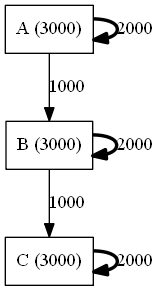

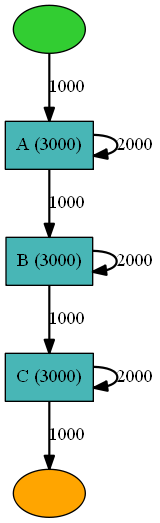

In [9]:
heu_net = importer.log_overview(log, 'sim', heuristic=True)['heuristic']

In [10]:
for k, conns in heu_net.nodes.items():
    print(k)
    print(conns)

A
(node:A connections:{A:[0.9995002498750625], B:[0.999000999000999]})
B
(node:B connections:{B:[0.9995002498750625], C:[0.999000999000999]})
C
(node:C connections:{C:[0.9995002498750625]})


In [11]:
lifecycles.lifecycle_census(log)

A
	count		valid	lifecycle sequence
	1000(100.00%)	True	('schedule', 'start', 'complete')
	total valid lifecycles: 1000/1000(100.00%)
B
	count		valid	lifecycle sequence
	1000(100.00%)	True	('schedule', 'start', 'complete')
	total valid lifecycles: 1000/1000(100.00%)
C
	count		valid	lifecycle sequence
	1000(100.00%)	True	('schedule', 'start', 'complete')
	total valid lifecycles: 1000/1000(100.00%)


In [12]:
activities = list(heu_net.nodes.keys())
edges = []
for k, conns in heu_net.nodes.items():
    for n in conns.output_connections.keys():
        if conns.output_connections[n][0].dependency_value > .7:
            if k != n.node_name:
                edges.append((k, n.node_name))
edges

[('A', 'B'), ('B', 'C')]

In [13]:
q_relations = experimental_lifecycle.QueueRelations()
q_relations.populate_relations(activities, edges)

In [14]:
lqa = experimental_lifecycle.LifecycleQueueAdapter()
qs = lqa.handle_log(log, q_relations)

In [65]:
q = qs['B']

In [66]:
{k: pd.Series(v).mean() for k, v in q.get_predecessor_waits().items()}

{'A': Timedelta('0 days 00:00:00')}

In [67]:
qr = q.get_replay()

In [68]:
qr.stats

{'queue events': 2000,
 'interesting queue exits': 635,
 'continuous lifo': 0.0,
 'lifo determinism measure_durations': 0.0,
 'continuous spt': 0.517667507470657,
 'spt determinism measure_durations': 0.43651401319464156}

<AxesSubplot:>

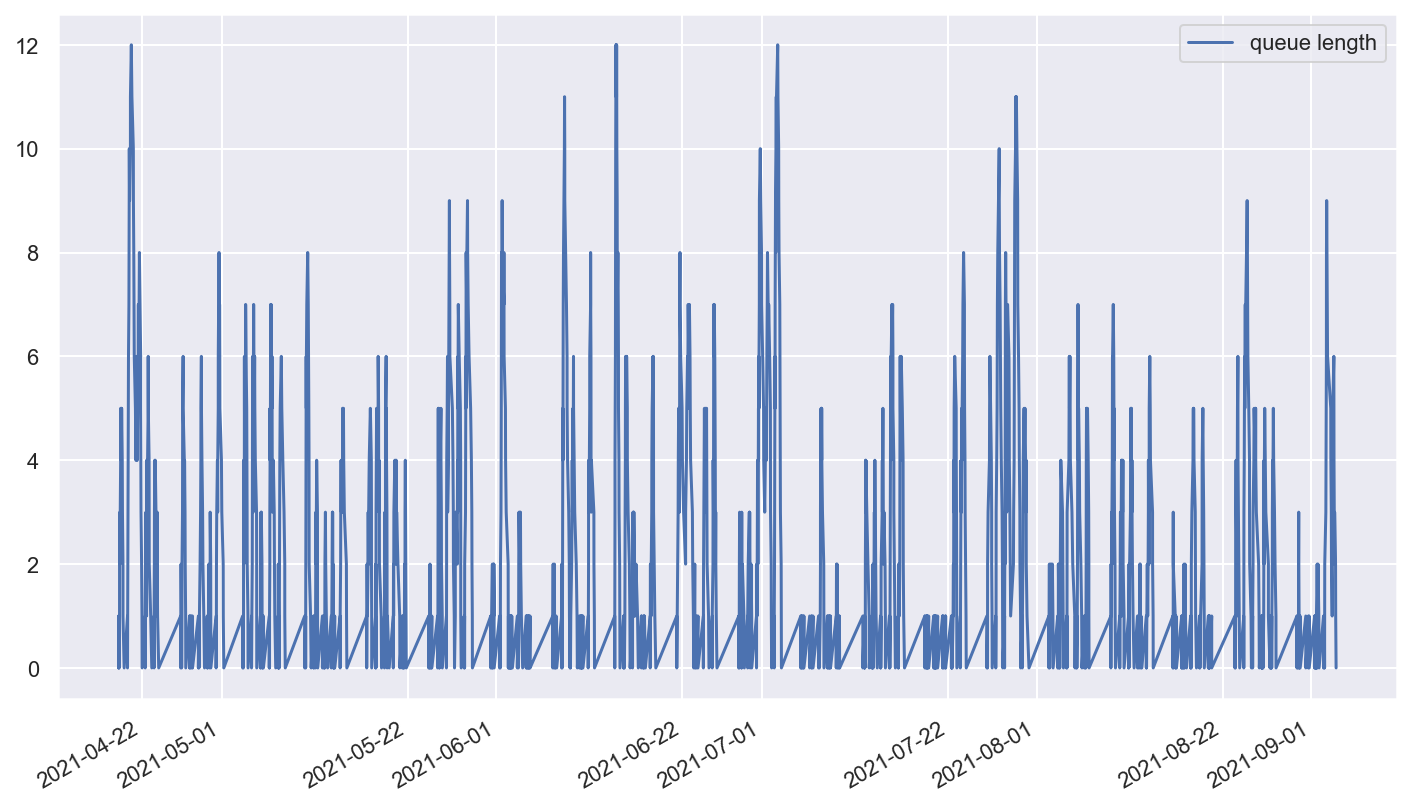

In [69]:
qr.total_ts.plot()

In [70]:
pr = q.get_processing_replay()

In [71]:
pr.stats

{'processing events': 2000,
 'concurrency occurred': 0,
 'continuous completion order': nan,
 'completion order determinism measure_durations': nan}

<AxesSubplot:>

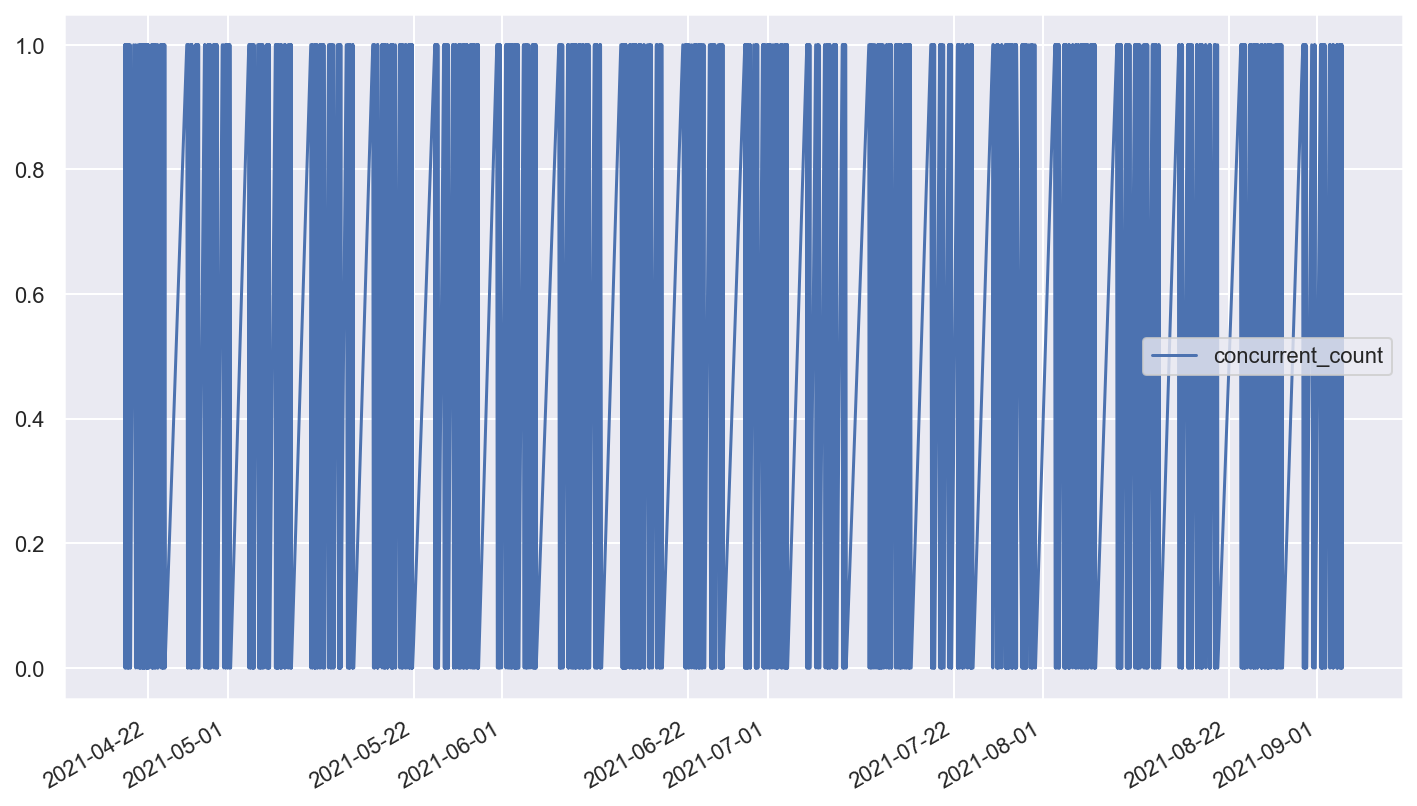

In [72]:
pr.total_ts.plot()

<ipython-input-73-d1c2bec08772>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ress = pr.total_ts.active_resources.apply(lambda counter: pd.Series(counter)).fillna(0)


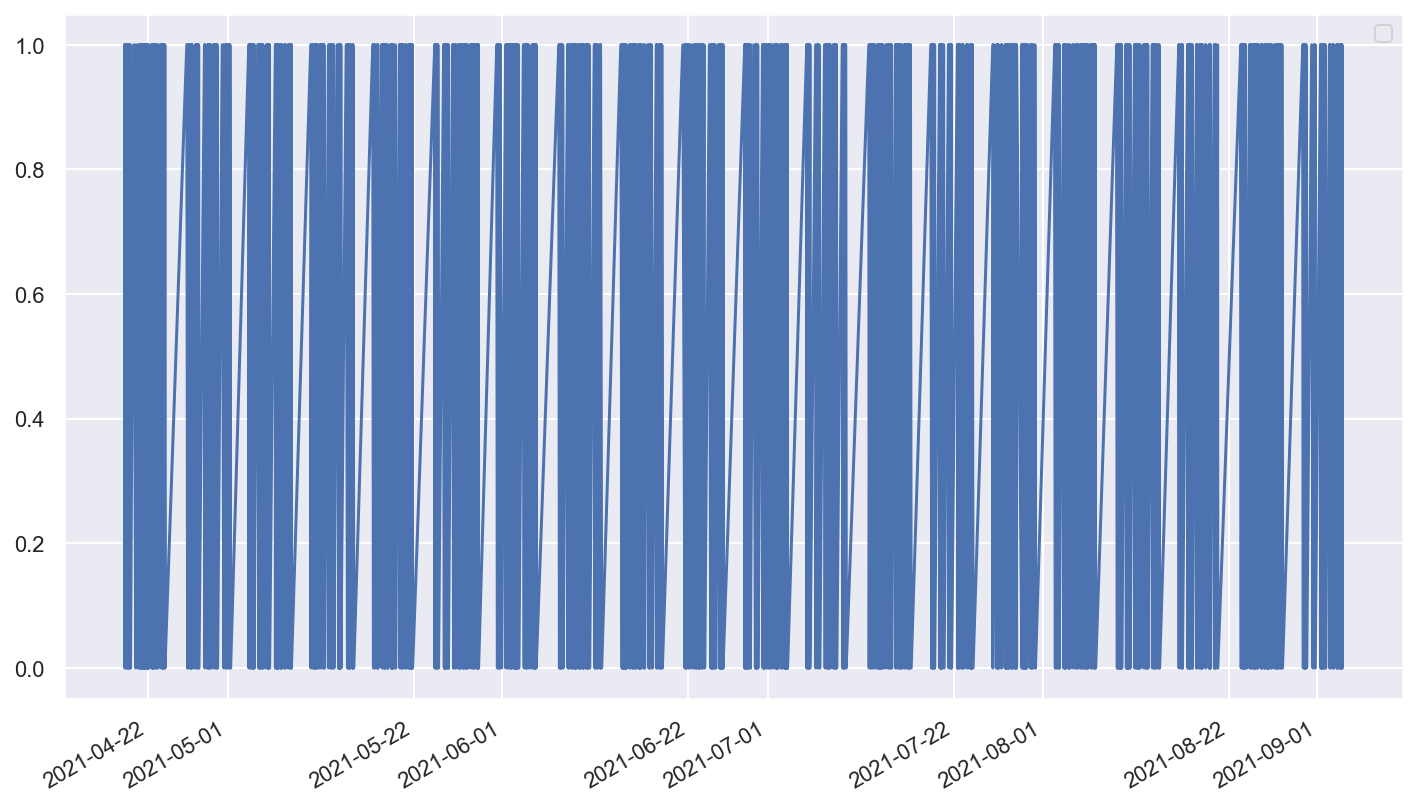

In [73]:
ress = pr.total_ts.active_resources.apply(lambda counter: pd.Series(counter)).fillna(0)
ress.plot(stacked=True)
plt.legend('')

In [74]:
df = q.get_data()

In [75]:
df.entry

0     2021-04-19 09:00:00
1     2021-04-19 09:29:00
2     2021-04-19 09:47:00
3     2021-04-19 11:24:00
4     2021-04-19 11:26:00
              ...        
995   2021-09-03 09:02:00
996   2021-09-03 09:27:00
997   2021-09-03 10:06:00
998   2021-09-03 13:02:00
999   2021-09-03 15:07:00
Name: entry, Length: 1000, dtype: datetime64[ns]

In [76]:
df.describe()

case_duration                       wait  \
count                       1000                       1000   
mean      0 days 07:50:30.131000     0 days 04:29:20.416000   
std    0 days 04:54:34.374587886  0 days 04:23:09.214243760   
min              0 days 00:02:00            0 days 00:00:00   
25%       0 days 04:03:00.750000     0 days 00:30:51.500000   
50%              0 days 07:08:35     0 days 03:34:33.500000   
75%              0 days 10:41:21     0 days 07:05:26.500000   
max              1 days 03:53:10            0 days 23:42:14   

                 processing_time  interruptions         qlen         qlex  \
count                       1000         1000.0  1000.000000  1000.000000   
mean      0 days 01:31:38.520000            0.0     2.198000     3.198000   
std    0 days 01:34:40.060853626            0.0     2.410935     2.410935   
min              0 days 00:00:00            0.0     0.000000     1.000000   
25%              0 days 00:24:00            0.0     0.000000     1.000000   
50%              0 days 01:00:00            0.0     1.000000     2.000000   
75%              0 days 02:04:15            0.0     4.000000     5.000000   
max              0 days 14:26:00            0.0    11.000000    12.000000   

          deq          spt  cont_deq    cont_spt    ccst    ccex  completion  \
count  1000.0  1000.000000     635.0  635.000000  1000.0  1000.0      1000.0   
mean      0.0     1.122000       0.0    0.517668     0.0     1.0         0.0   
std       0.0     1.678074       0.0    0.402436     0.0     0.0         0.0   
min       0.0     0.000000       0.0    0.000000     0.0     1.0         0.0   
25%       0.0     0.000000       0.0    0.000000     0.0     1.0         0.0   
50%       0.0     0.000000       0.0    0.500000     0.0     1.0         0.0   
75%       0.0     2.000000       0.0    1.000000     0.0     1.0         0.0   
max       0.0    10.000000       0.0    1.000000     0.0     1.0         0.0   

       cont_comp  
count        0.0  
mean         NaN  
std          NaN  
min          NaN  
25%          NaN  
50%          NaN  
75%          NaN  
max          NaN

In [77]:
df.groupby('exit_resource')['processing_time'].sum()

exit_resource
R2   63 days 15:22:00
Name: processing_time, dtype: timedelta64[ns]

In [78]:
df['start'].dt.time.groupby(df.start.dt.dayofweek).agg(['min','max'])

min       max
start                    
0      09:00:00  23:54:09
1      00:02:10  23:54:09
2      00:03:07  23:49:10
3      00:12:26  23:46:22
4      00:01:11  23:40:09
5      00:03:09  07:21:11

In [79]:
hh = df['start'].dt.time.apply(['min','max'])
10/24 * (df.start.iloc[-1] - df.start.iloc[0]).days

57.083333333333336

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='interruptions', ylabel='Density'>

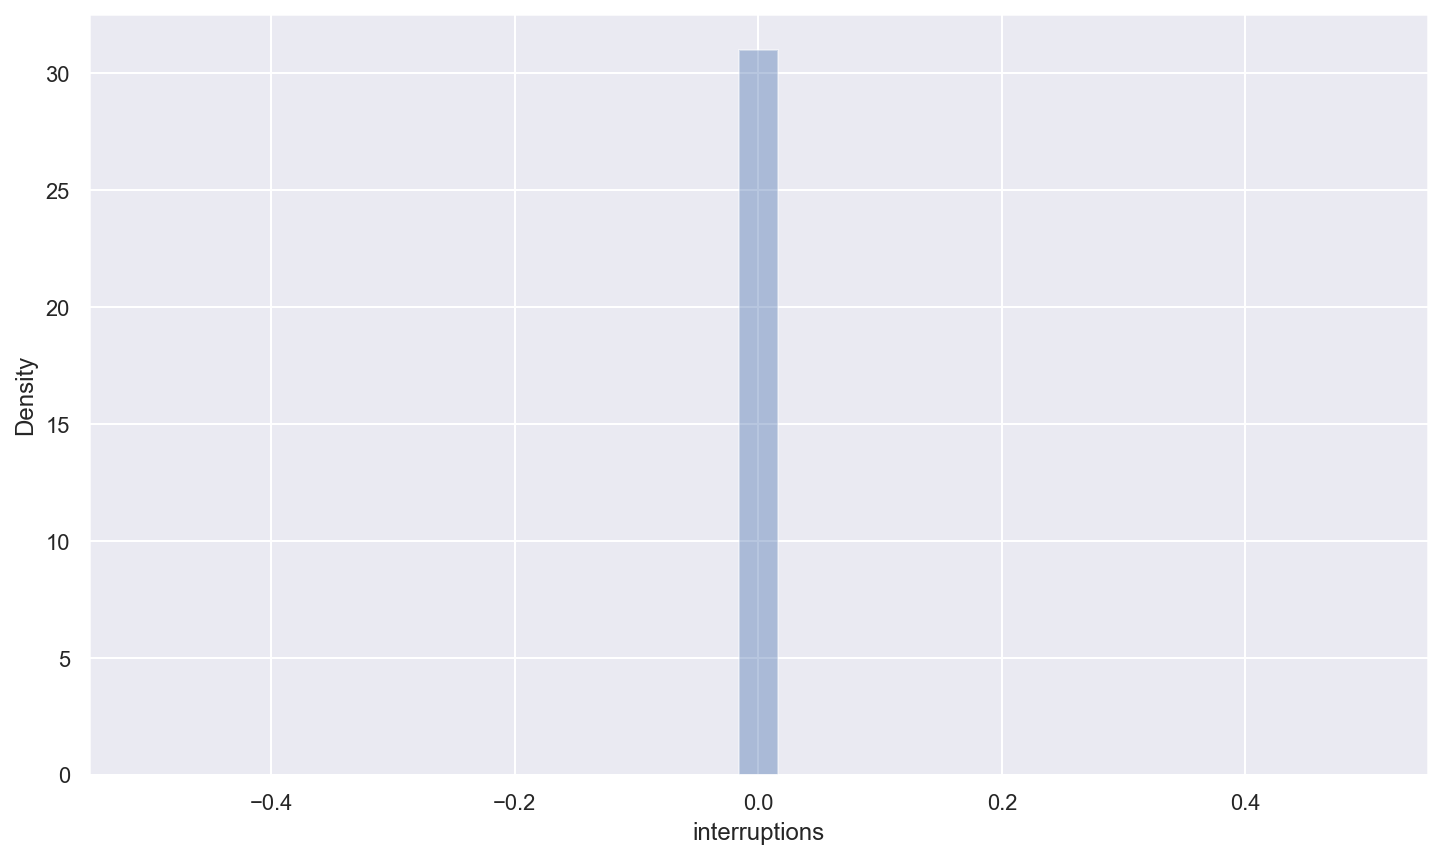

In [80]:
sns.distplot(df.interruptions)

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


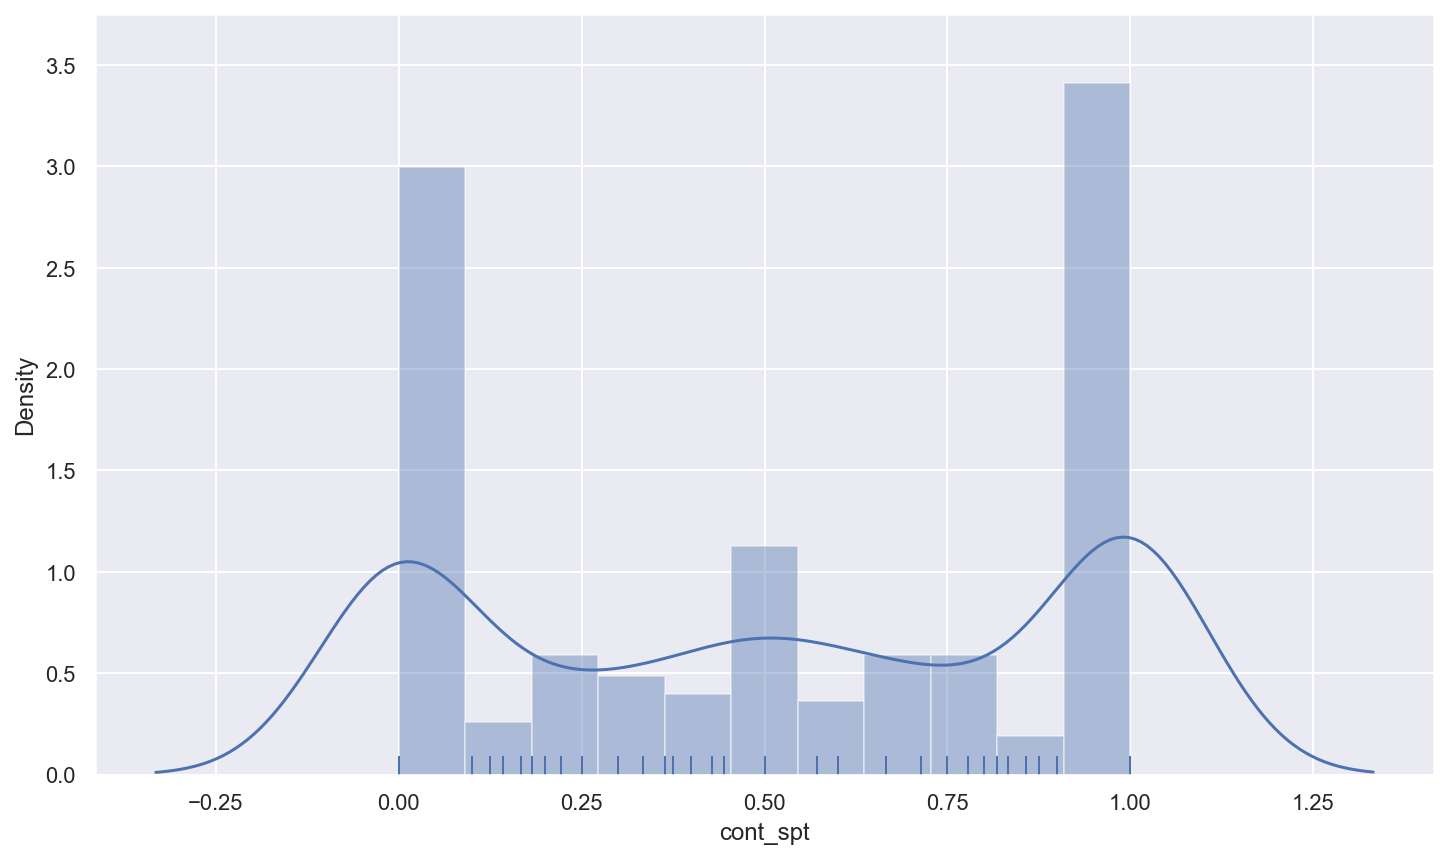

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cont_deq', ylabel='Density'>

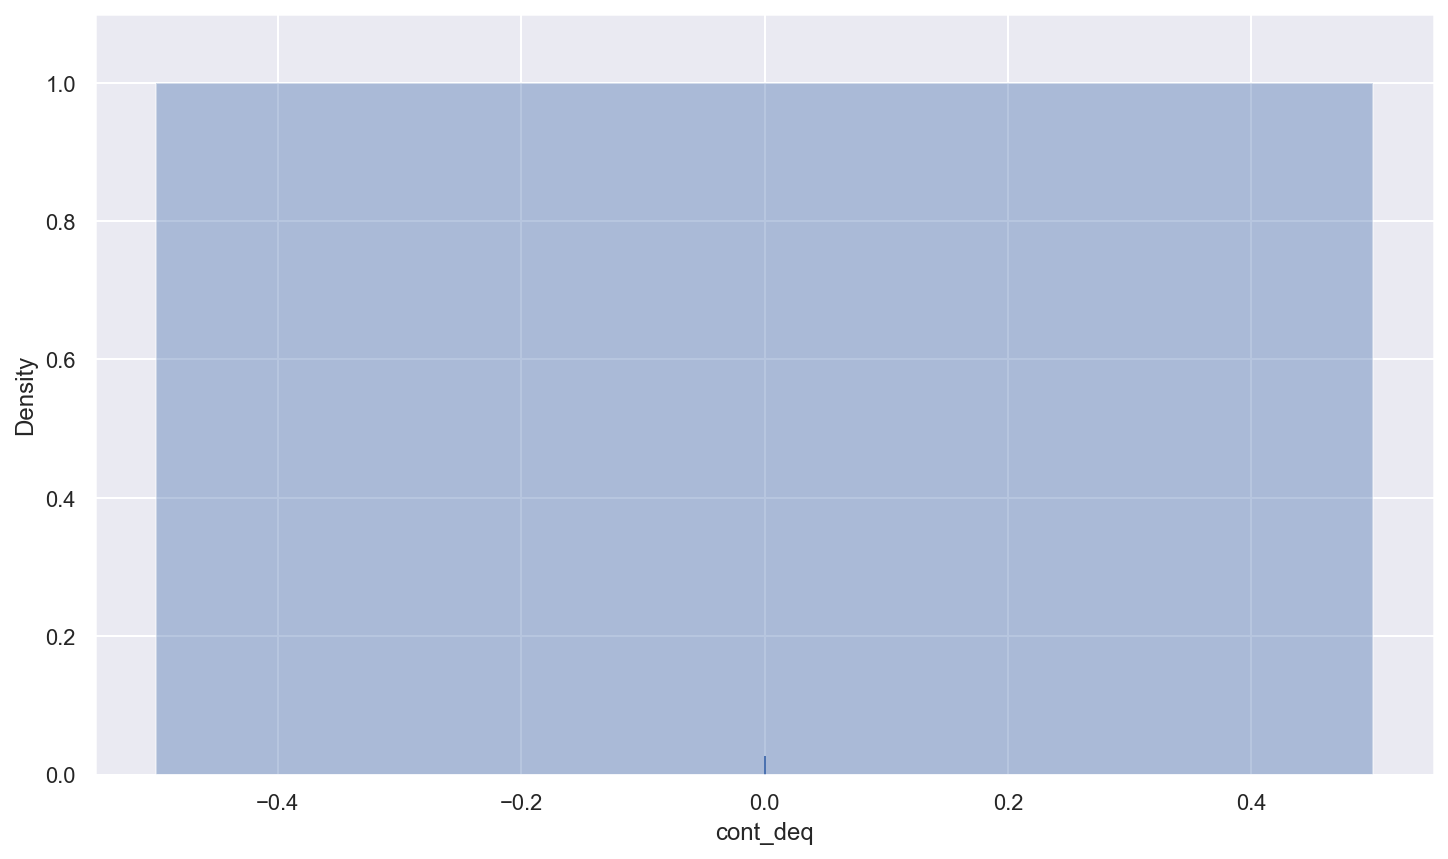

In [81]:
viz.my_hist(df.cont_spt)
plt.show()
viz.my_hist(df.cont_deq)

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<AxesSubplot:xlabel='cont_comp'>

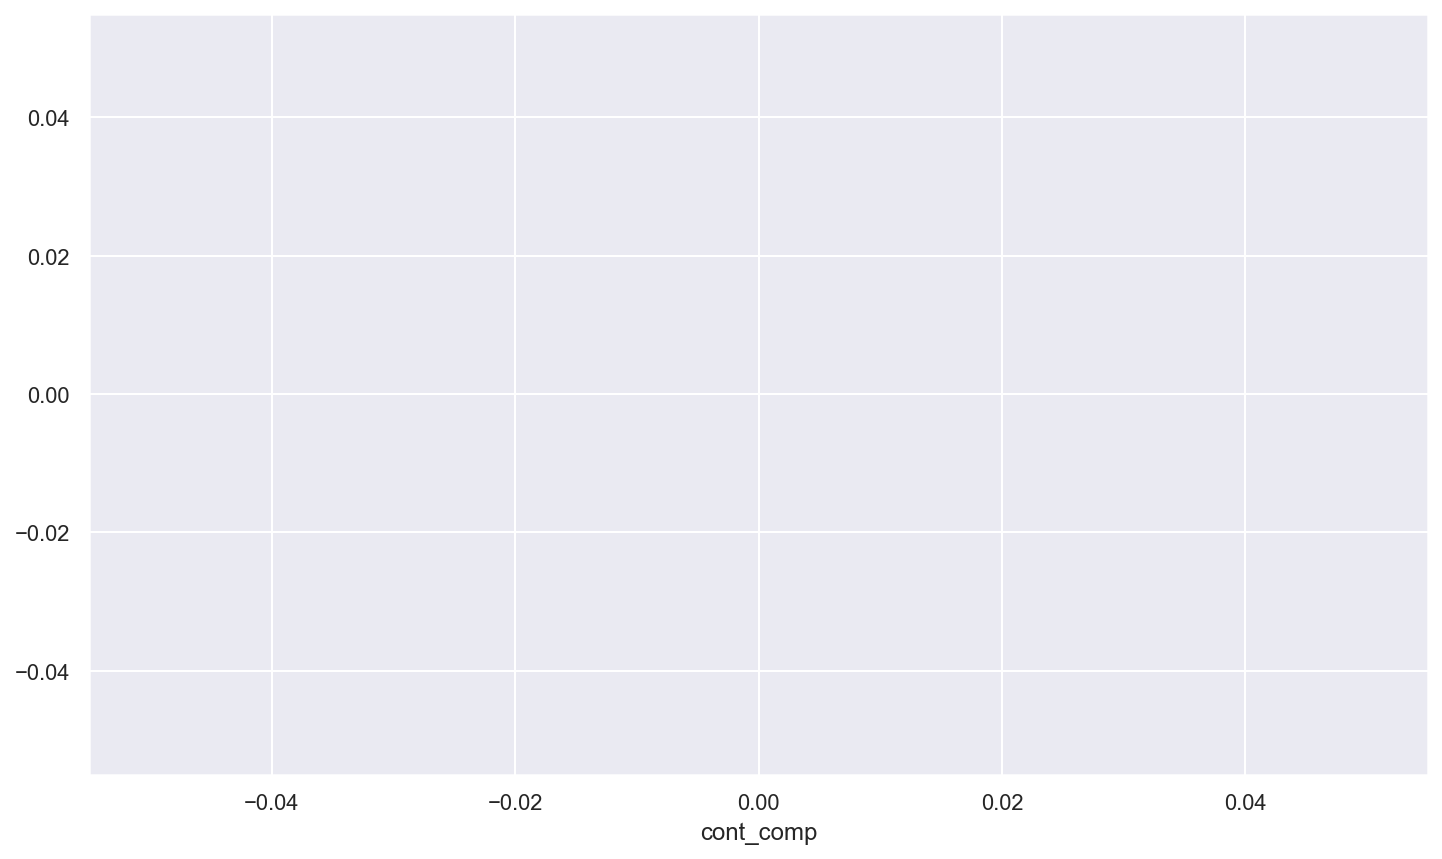

In [82]:
sns.distplot(df.cont_comp)

In [83]:
df.entry_resource.value_counts()

n/a    1000
Name: entry_resource, dtype: int64

In [84]:
df.start_resource.value_counts()

R2    1000
Name: start_resource, dtype: int64

In [85]:
df.exit_resource.value_counts()

R2    1000
Name: exit_resource, dtype: int64

In [86]:
counts = df.exit_resource.value_counts(normalize=True)
util.entropy(counts) / np.log(len(counts))

<ipython-input-86-faaba44c51c9>:2: RuntimeWarning: invalid value encountered in double_scalars
  util.entropy(counts) / np.log(len(counts))


nan

In [87]:
en_r = 'entry_resource'
st_r = 'start_resource'
ex_r = 'exit_resource'
print((df[en_r] == df[st_r]).value_counts())
print((df[st_r] == df[ex_r]).value_counts())
print(((df[en_r] == df[st_r]) & (df[st_r] == df[ex_r])).value_counts())

False    1000
dtype: int64
True    1000
dtype: int64
False    1000
dtype: int64


In [88]:
df.wait.mean()

Timedelta('0 days 04:29:20.416000')

In [89]:
df.case_duration.mean()

Timedelta('0 days 07:50:30.131000')

In [90]:
df.processing_time.mean()

Timedelta('0 days 01:31:38.520000')

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


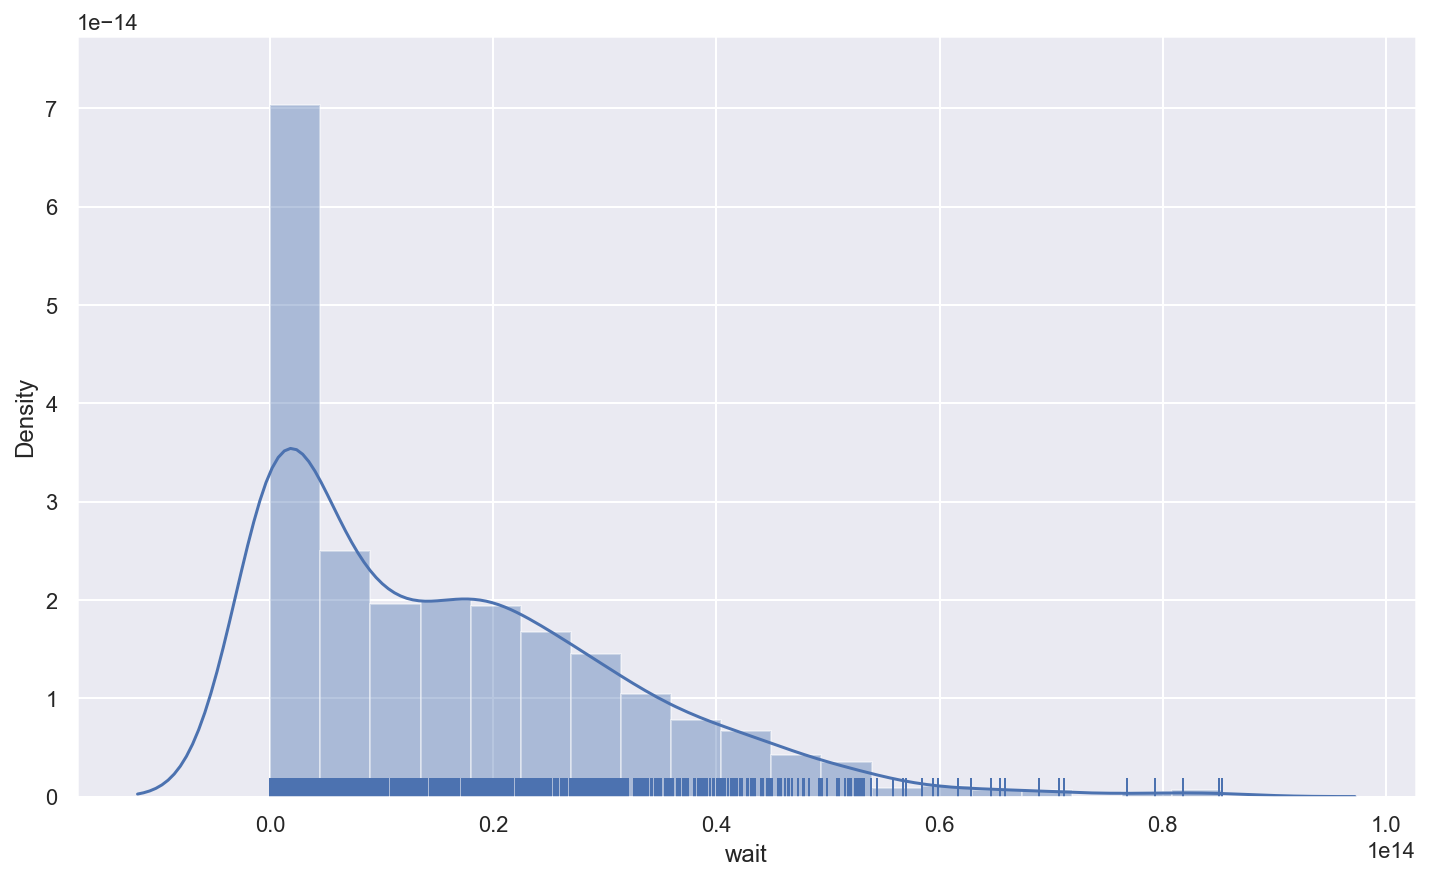

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='processing_time', ylabel='Density'>

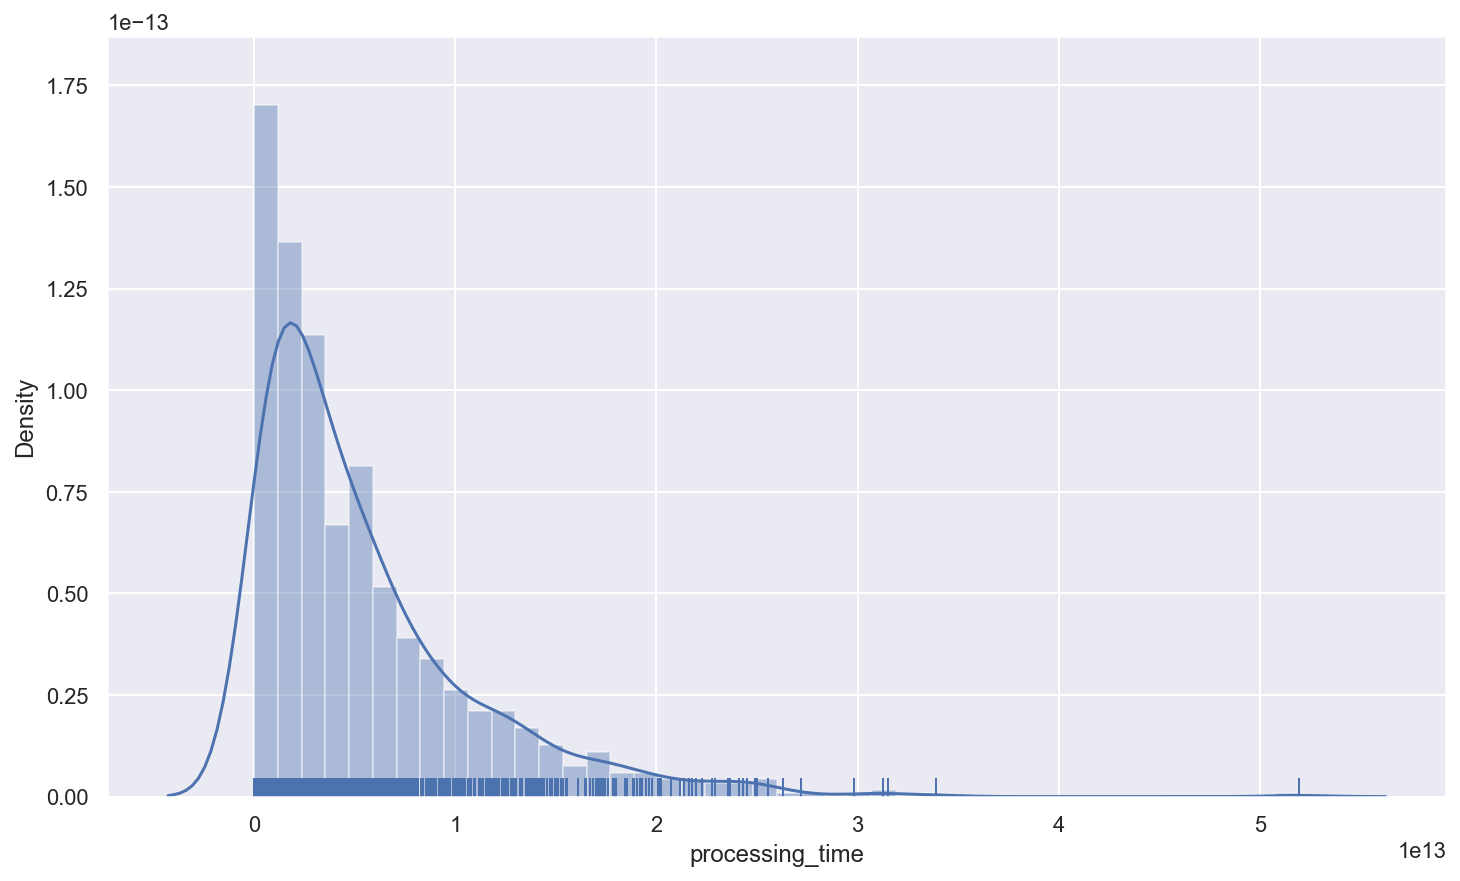

In [91]:
viz.my_hist(df.wait)
plt.show()
viz.my_hist(df.processing_time)

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='case_duration', ylabel='Density'>

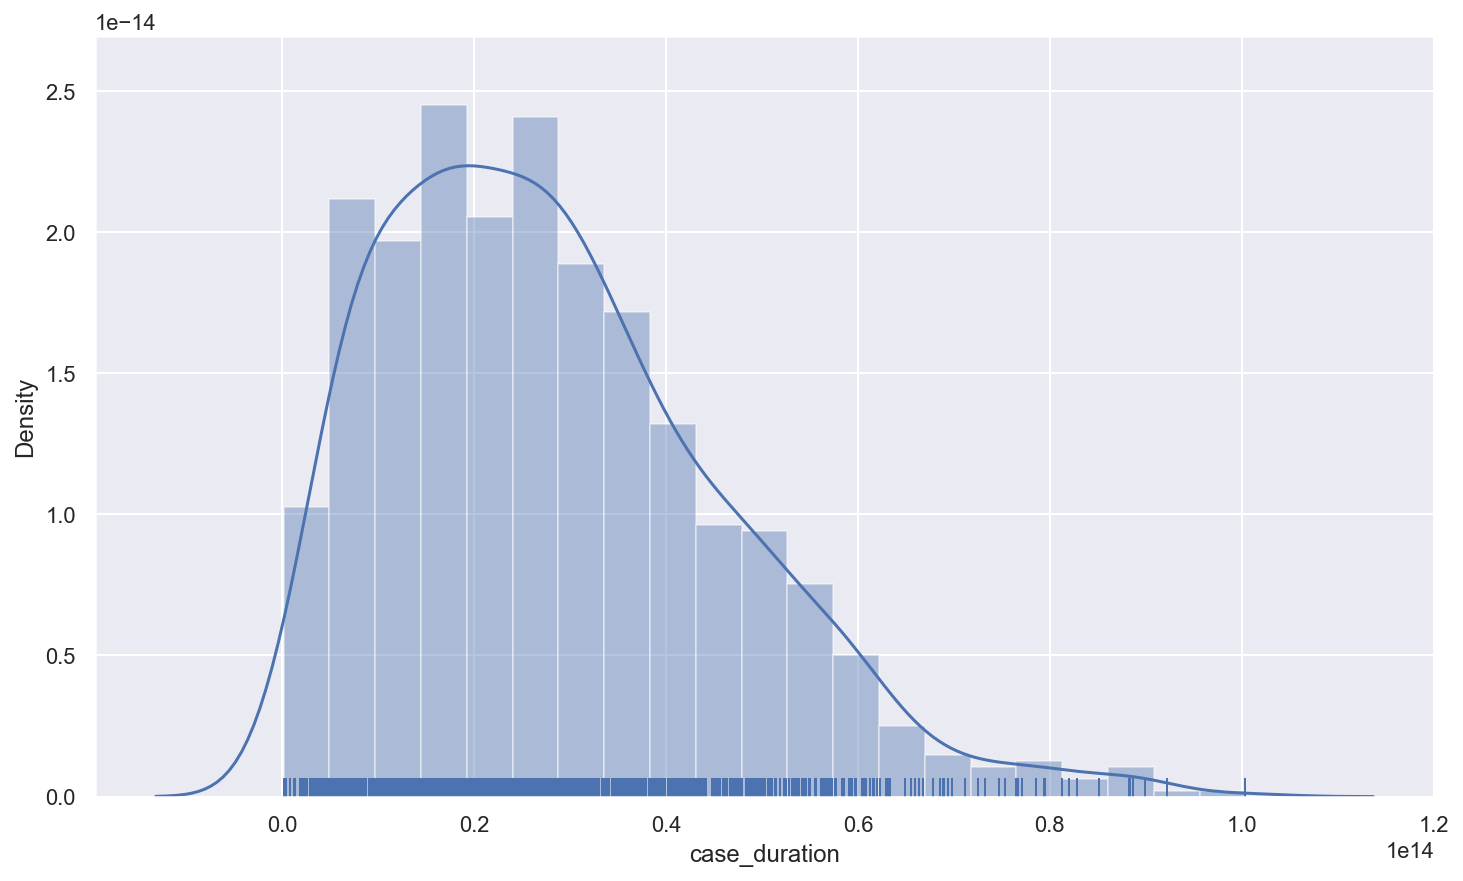

In [92]:
viz.my_hist(df.case_duration, normalized=True)

0.7156621177296544


<AxesSubplot:>

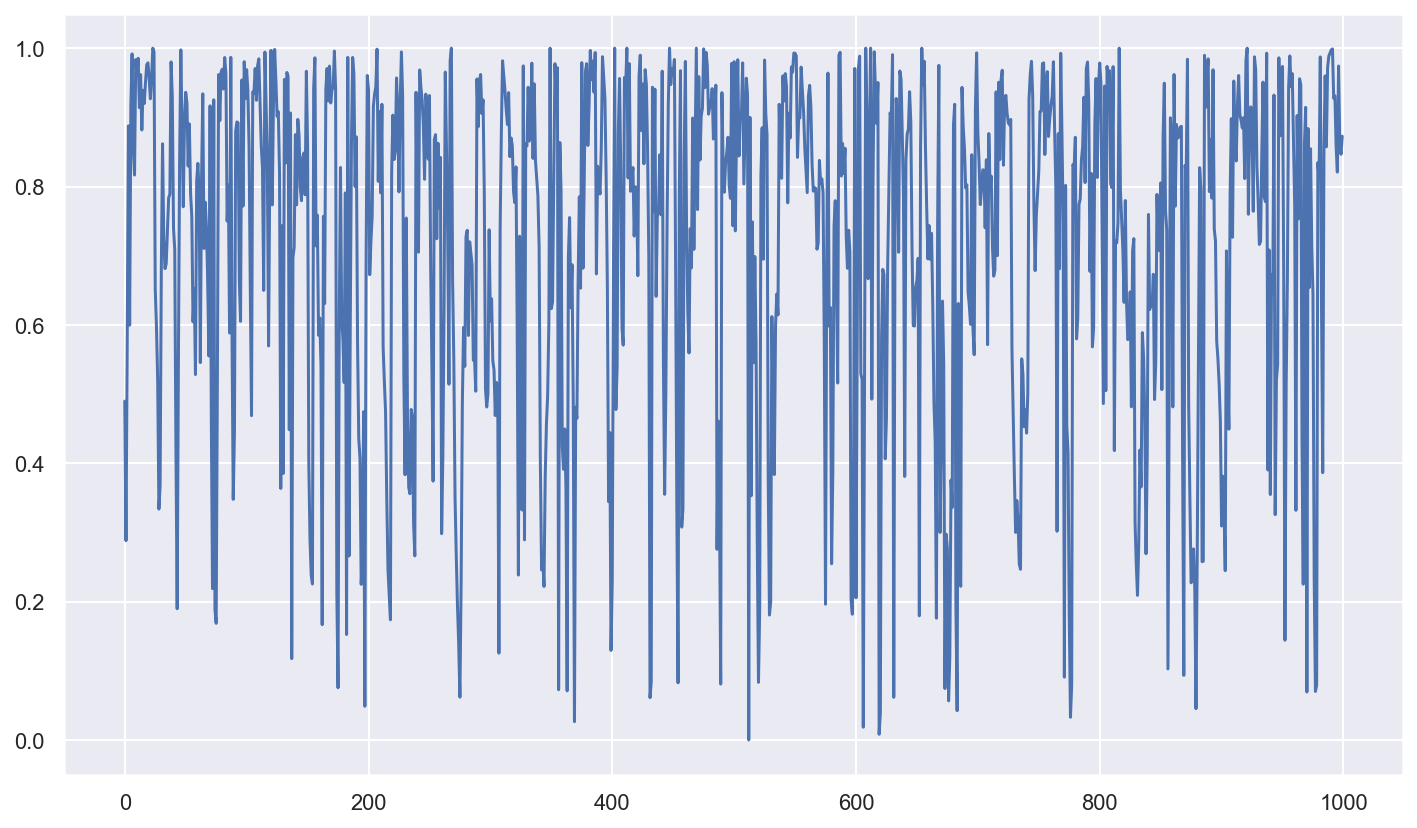

In [93]:
frac = (df.wait + df.processing_time) / df.case_duration
print(frac.mean())
frac.plot()

In [94]:
(df.wait / df.processing_time).mean()

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\pandas\core\arrays\timedeltas.py:569: RuntimeWarning: divide by zero encountered in true_divide
  return other / self._data
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\pandas\core\arrays\timedeltas.py:569: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


inf

In [95]:
ias = q.get_interarrivals()

In [96]:
ias

entry        entry_ia               start        start_ia  \
0   2021-04-19 09:00:00 0 days 00:29:00 2021-04-19 09:00:00 0 days 00:29:00   
1   2021-04-19 09:29:00 0 days 00:18:00 2021-04-19 09:29:00 0 days 00:51:01   
2   2021-04-19 09:47:00 0 days 01:37:00 2021-04-19 10:20:01 0 days 02:18:01   
3   2021-04-19 11:24:00 0 days 00:02:00 2021-04-19 12:38:02 0 days 02:51:01   
4   2021-04-19 11:26:00 0 days 00:49:00 2021-04-19 15:29:03 0 days 00:40:01   
..                  ...             ...                 ...             ...   
994 2021-09-03 09:00:00 0 days 00:02:00 2021-09-03 13:25:11 0 days 00:42:01   
995 2021-09-03 09:02:00 0 days 00:25:00 2021-09-03 14:07:12 0 days 00:43:01   
996 2021-09-03 09:27:00 0 days 00:39:00 2021-09-03 14:50:13 0 days 02:47:01   
997 2021-09-03 10:06:00 0 days 02:56:00 2021-09-03 17:37:14 0 days 00:23:01   
998 2021-09-03 13:02:00 0 days 02:05:00 2021-09-03 18:00:15 0 days 01:06:01   

                   exit         exit_ia  
0   2021-04-19 09:24:00 0 days 00:56:00  
1   2021-04-19 10:20:00 0 days 02:18:01  
2   2021-04-19 12:38:01 0 days 02:51:01  
3   2021-04-19 15:29:02 0 days 00:40:01  
4   2021-04-19 16:09:03 0 days 02:37:01  
..                  ...             ...  
994 2021-09-03 14:07:11 0 days 00:43:01  
995 2021-09-03 14:50:12 0 days 02:47:01  
996 2021-09-03 17:37:13 0 days 00:23:01  
997 2021-09-03 18:00:14 0 days 01:06:01  
998 2021-09-03 19:06:15 0 days 00:42:01  

[999 rows x 6 columns]

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\da

<AxesSubplot:xlabel='exit_ia', ylabel='Density'>

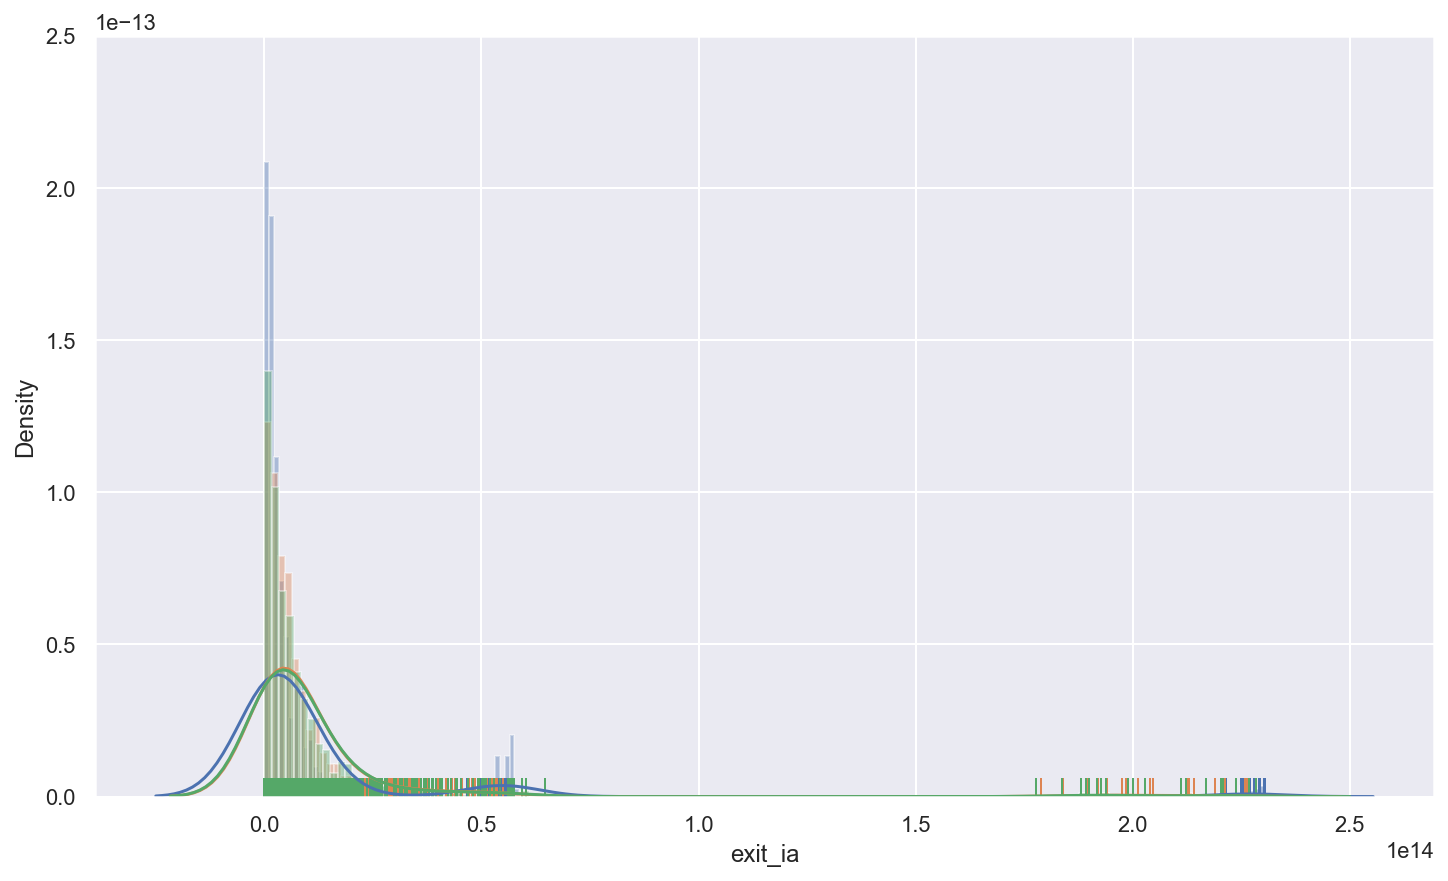

In [97]:
viz.my_hist(ias.entry_ia)
viz.my_hist(ias.start_ia)
viz.my_hist(ias.exit_ia)

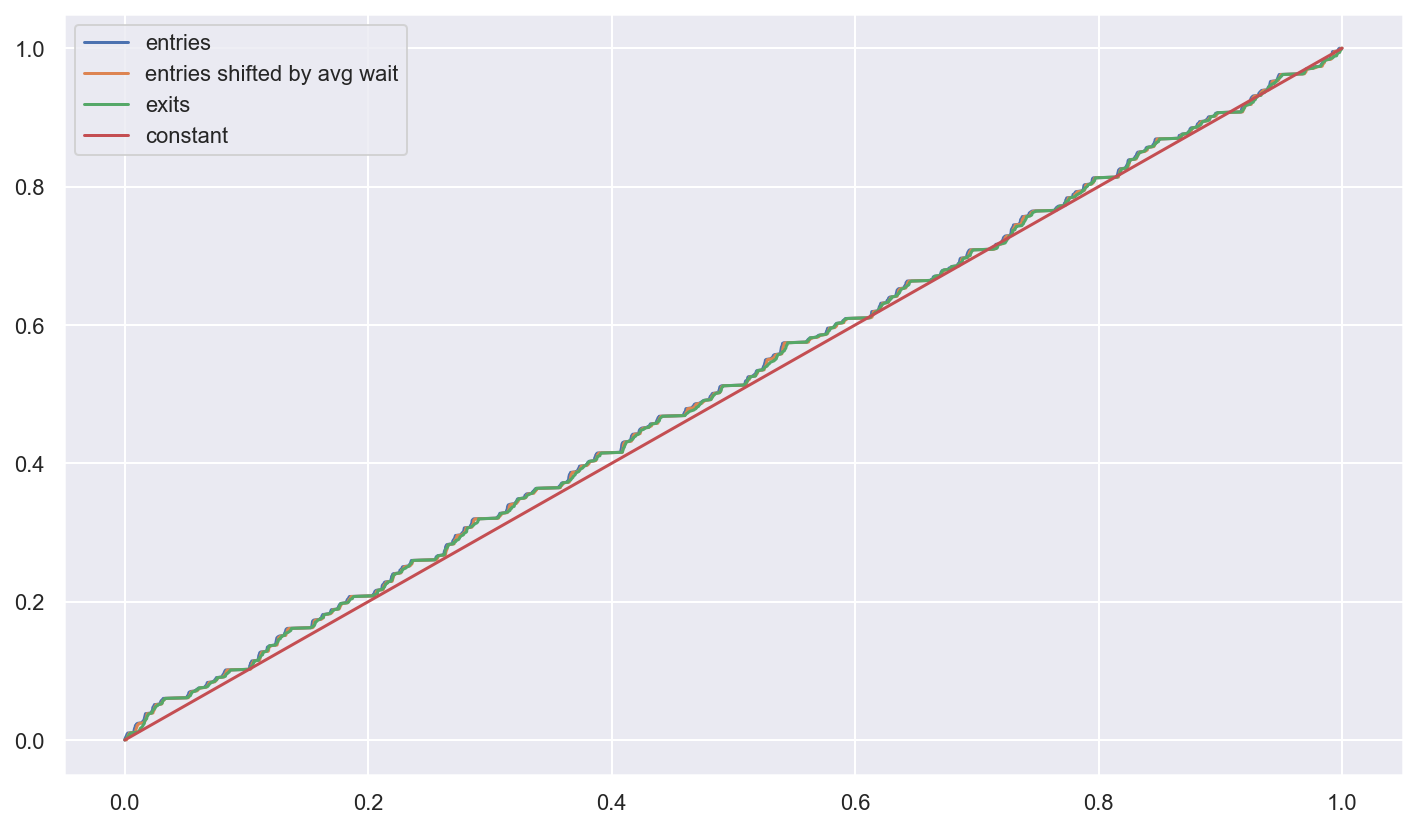

In [98]:
viz.vis_iat_over_time(q)

In [99]:
df.qlen.corr(df.wait.dt.total_seconds())

0.8095601714024183

In [100]:
df.ccst.corr(df.processing_time.dt.total_seconds())

nan

<AxesSubplot:xlabel='entry'>

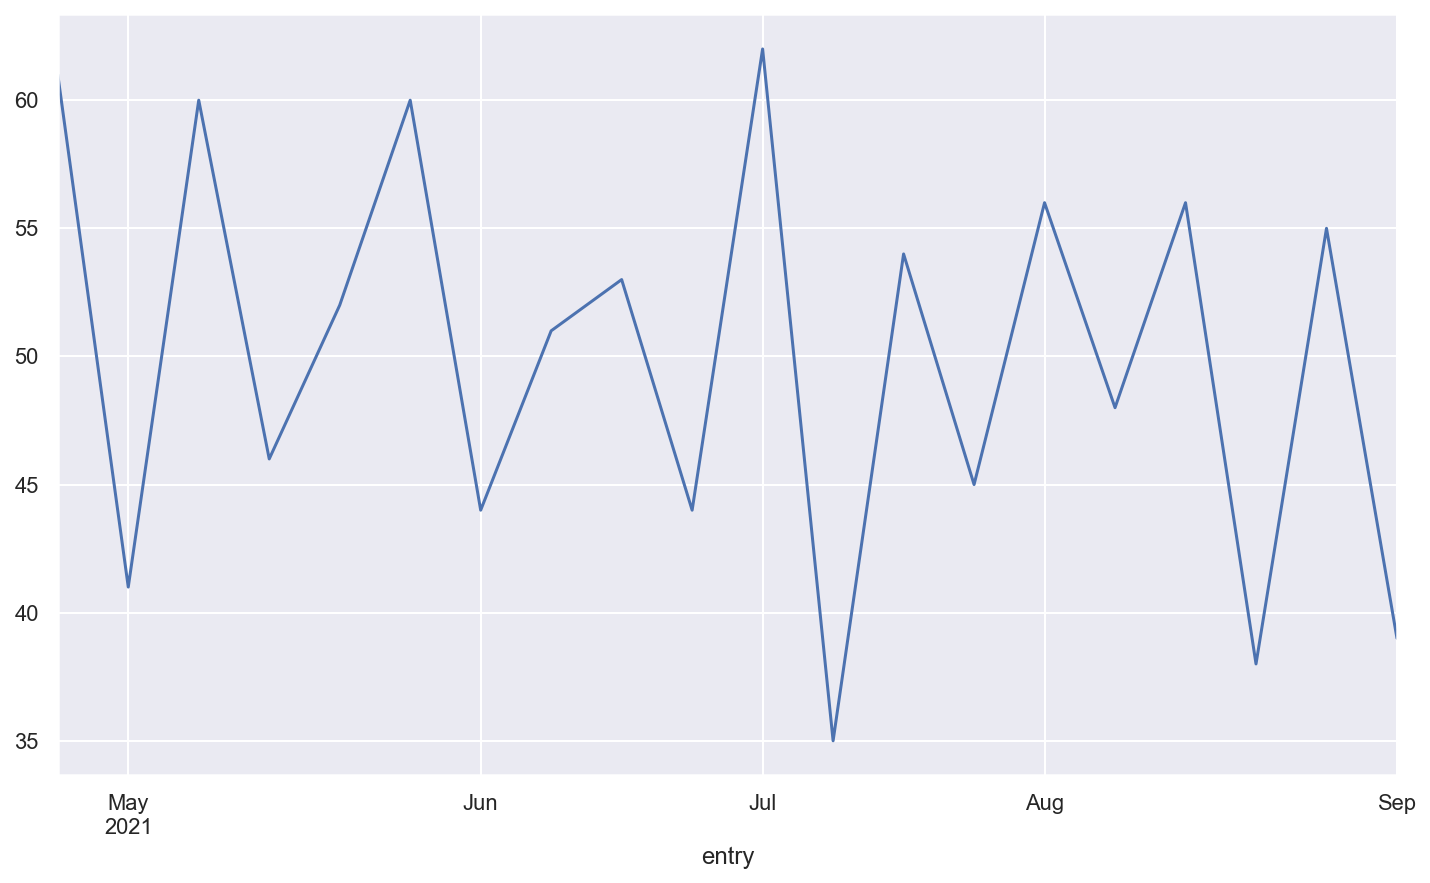

In [101]:
df.set_index('entry').resample('1w').size().plot()

<AxesSubplot:xlabel='start'>

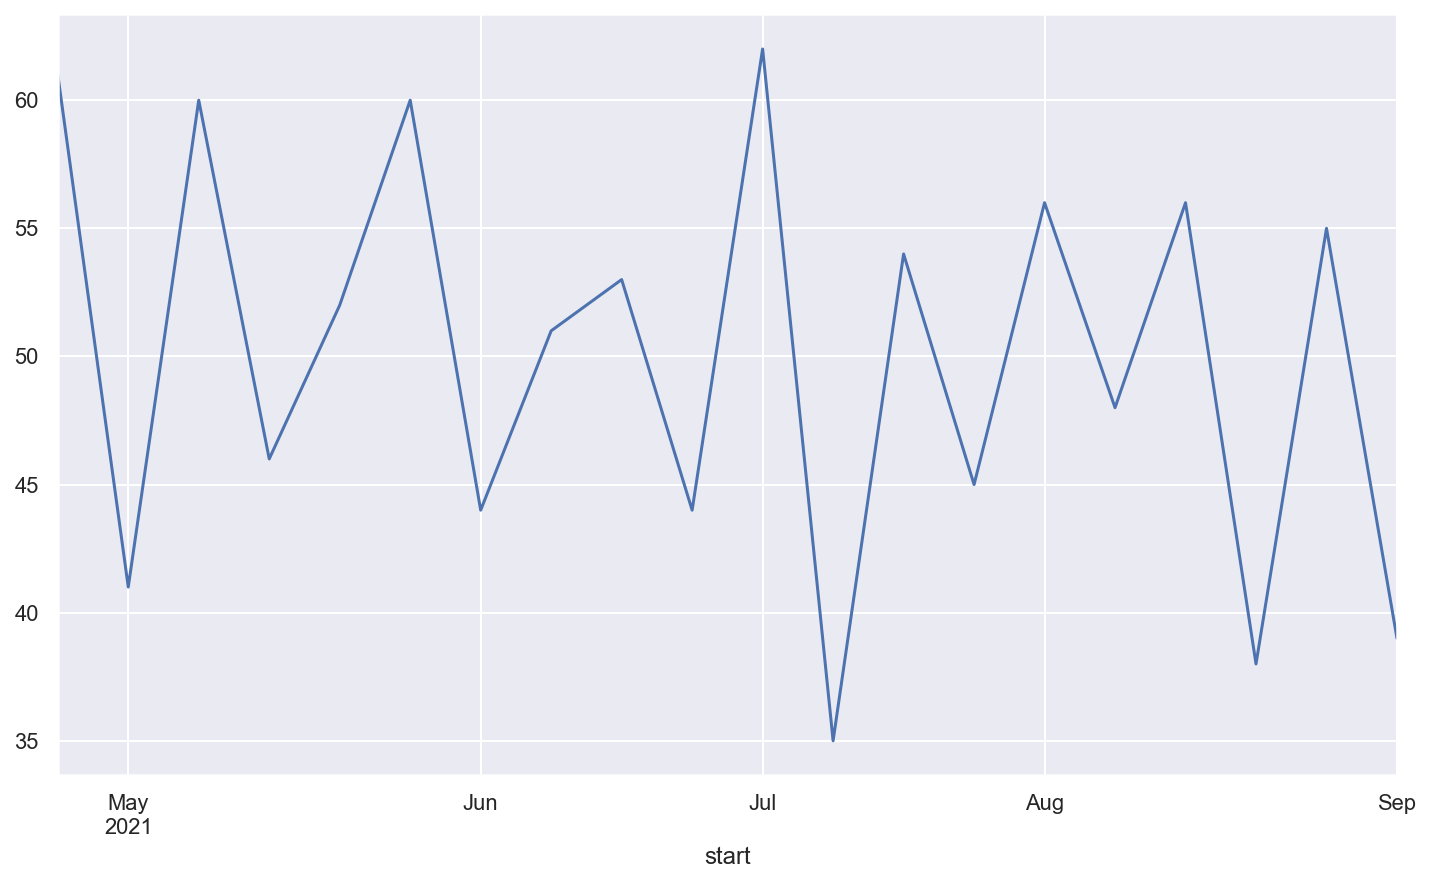

In [102]:
df.set_index('start').resample('1w').size().plot()

<AxesSubplot:xlabel='exit'>

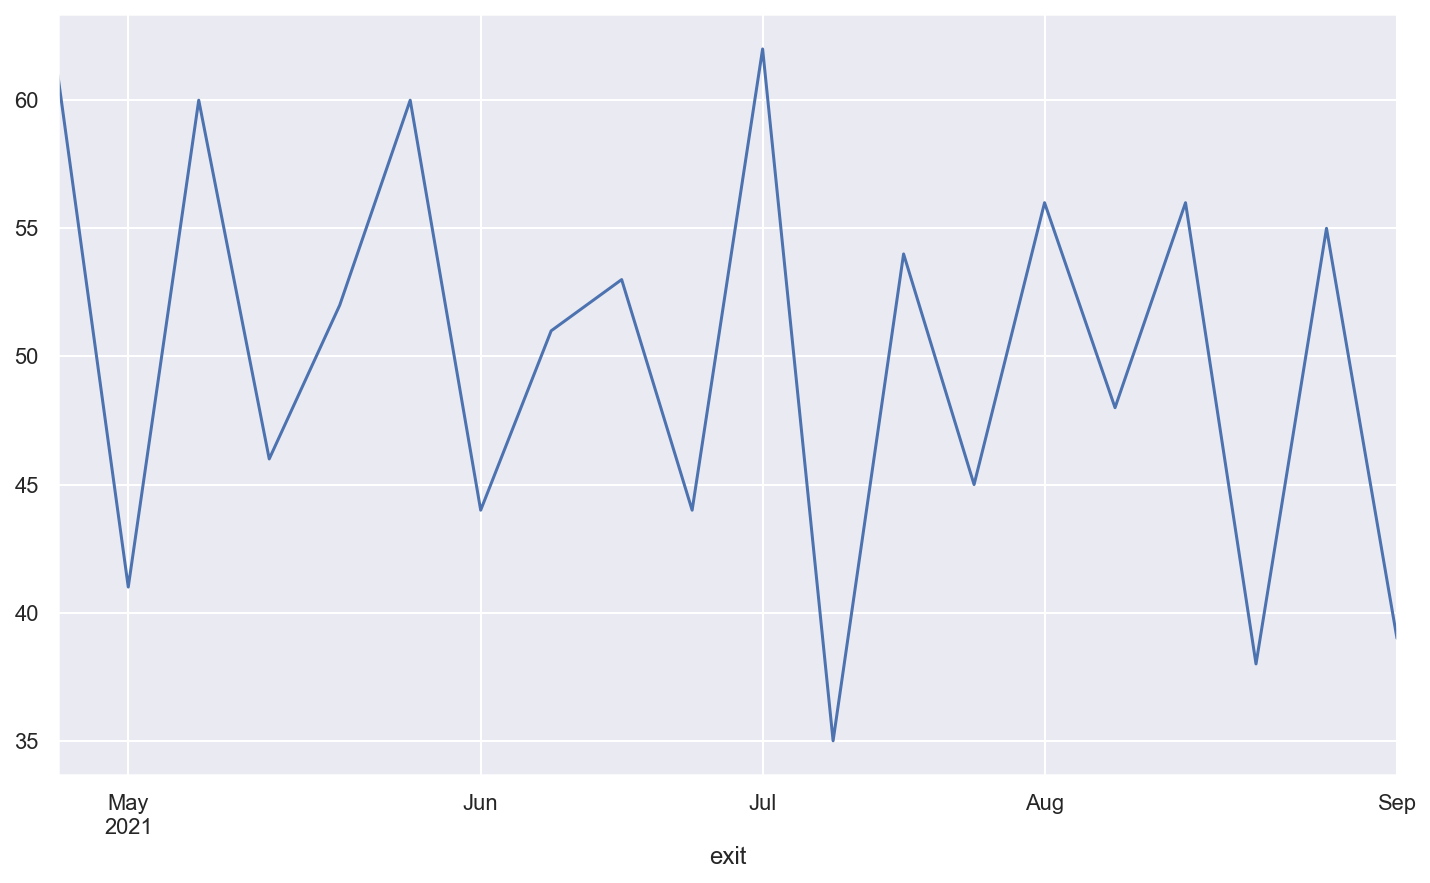

In [103]:
df.set_index('exit').resample('1w').size().plot()

In [104]:
import scipy
ias = q.get_interarrivals()
obs_period = q.get_observation_period()
obs_start = q.get_observation_start()
normed_exit_count = (ias.start - obs_start) / obs_period
normed_entry_count = (ias.entry - obs_start) / obs_period
df = q.get_data()
normed_shifted_entry_count = (ias.entry + df.wait.mean() - obs_start) / obs_period
entry_int = scipy.integrate.trapz(np.linspace(0, 1, len(ias)), normed_entry_count)
shifted_entry_int = scipy.integrate.trapz(np.linspace(0, 1, len(ias)), normed_shifted_entry_count)
exit_int = scipy.integrate.trapz(np.linspace(0, 1, len(ias)), normed_exit_count)
batching_maybe = abs(shifted_entry_int - exit_int) > 0.01

test_1 = scipy.stats.anderson_ksamp([ias.entry_ia, ias.exit_ia]).significance_level <= 0.001
test_2 = scipy.stats.ks_2samp(ias.entry_ia, ias.exit_ia).pvalue <= 0.001
ias_differ = test_1 and test_2

bursty_entry = util.burstiness(ias.entry_ia) > .5
bursty_exit = util.burstiness(ias.exit_ia) > .5

<ipython-input-104-2279e1082c27>:14: UserWarning: p-value floored: true value smaller than 0.001
  test_1 = scipy.stats.anderson_ksamp([ias.entry_ia, ias.exit_ia]).significance_level <= 0.001


In [105]:
entry_int, shifted_entry_int, exit_int

(0.5109728863322747, 0.5109728863322747, 0.5111181871716692)

In [106]:
util.dist_change(df, 'wait', 'predecessors')

(False, [])

c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\daniel\pycharmprojects\pm\venv\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


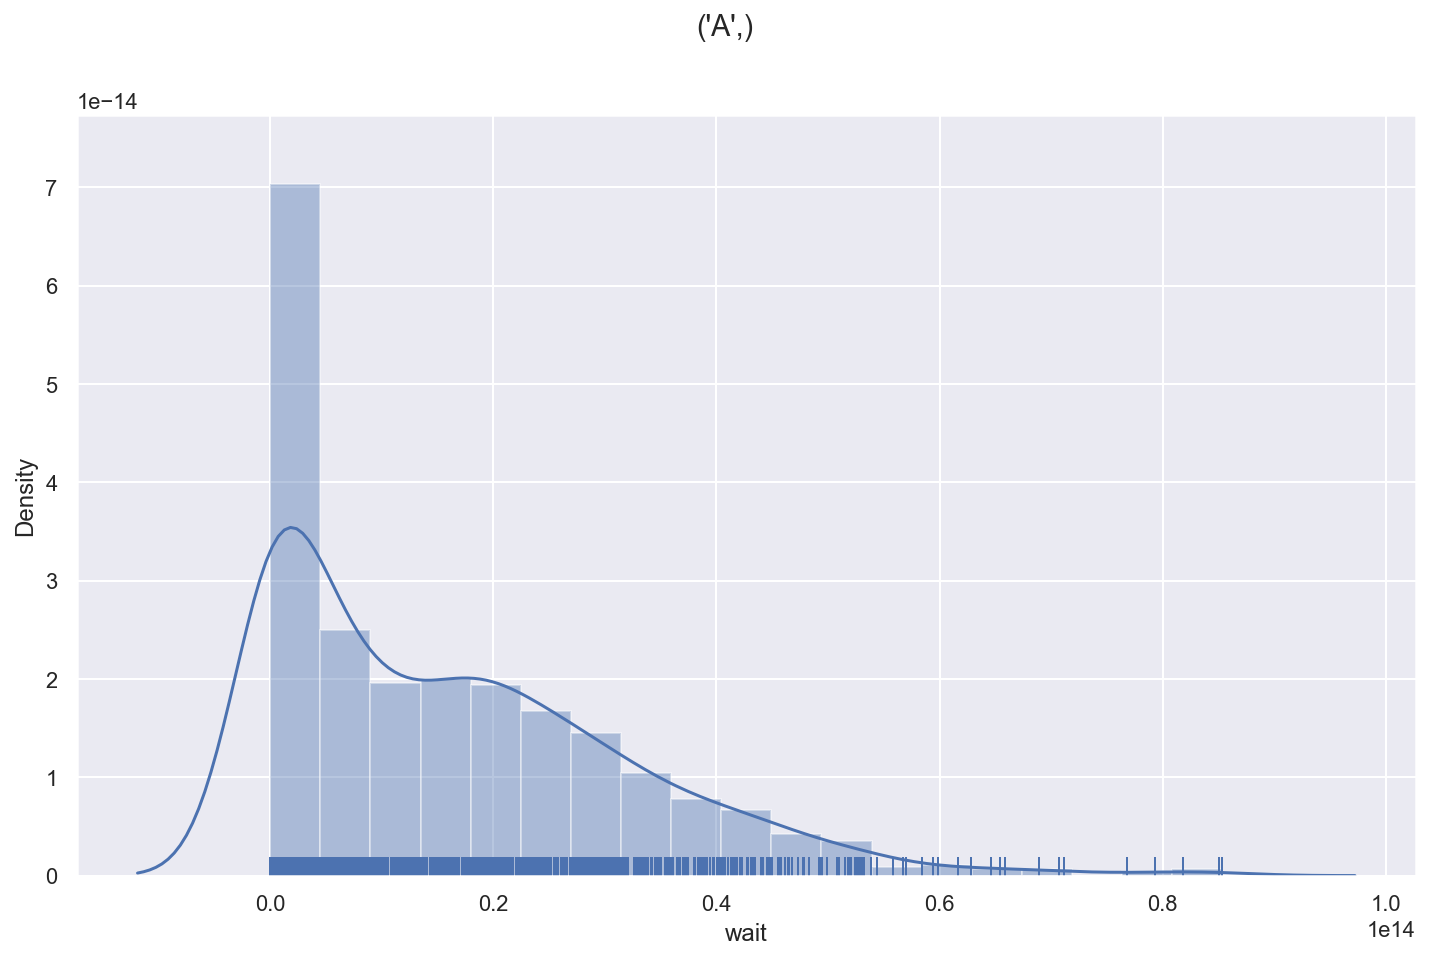

In [107]:
gr = df.groupby('predecessors')
for k, v in gr.groups.items():
    viz.my_hist(df.loc[v]['wait'])
    plt.suptitle(k)

In [108]:
import pivots
import datetime

<AxesSubplot:xlabel='entry'>

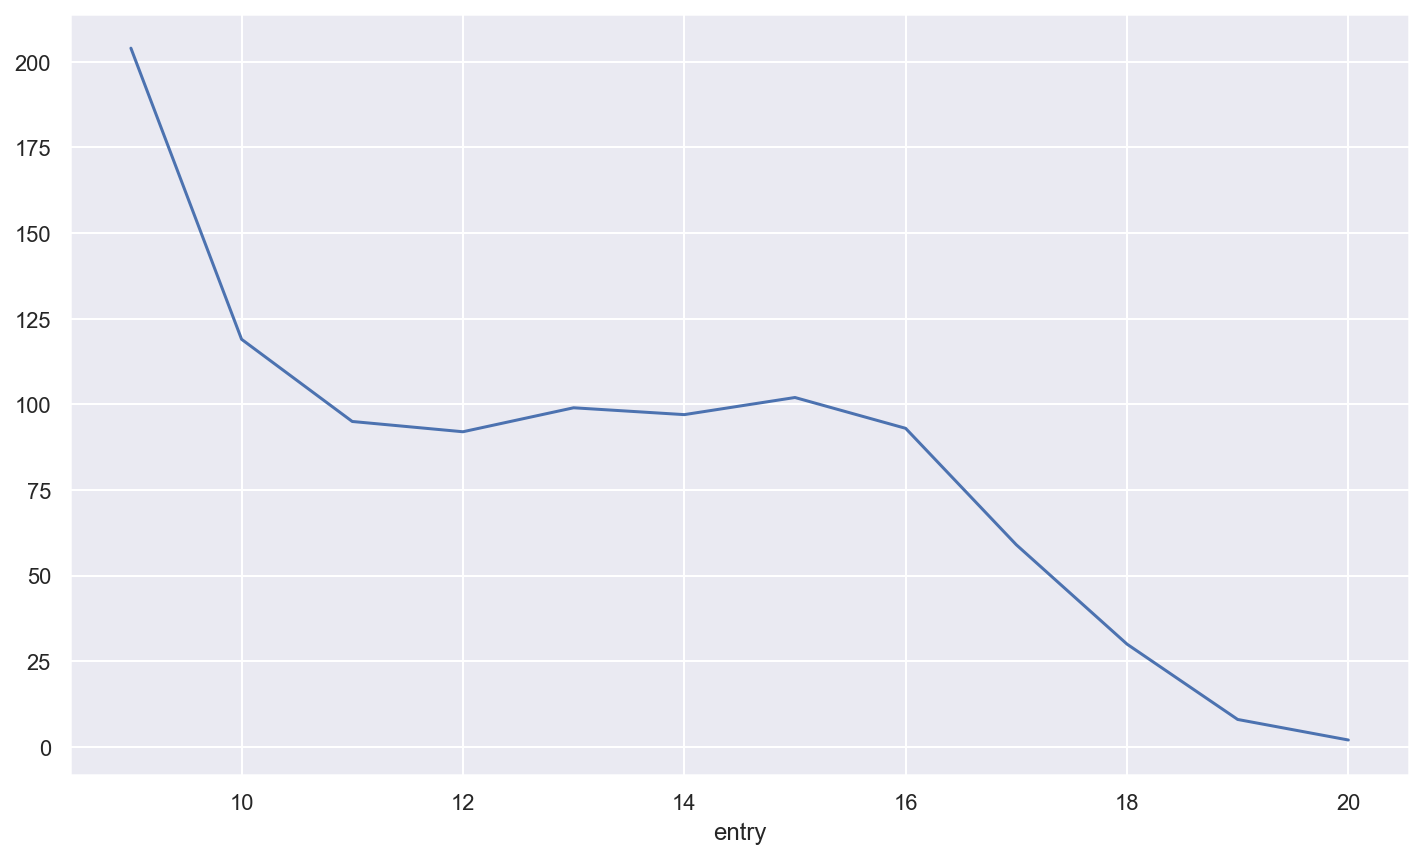

In [109]:
df.groupby(df.entry.dt.hour).size().plot()

([<matplotlib.axis.XTick at 0x14d28dfbeb0>,
 [Text(0, 0, '00:00:00'),
  Text(4, 0, '04:00:00'),
  Text(8, 0, '08:00:00'),
  Text(12, 0, '12:00:00'),
  Text(16, 0, '16:00:00')])

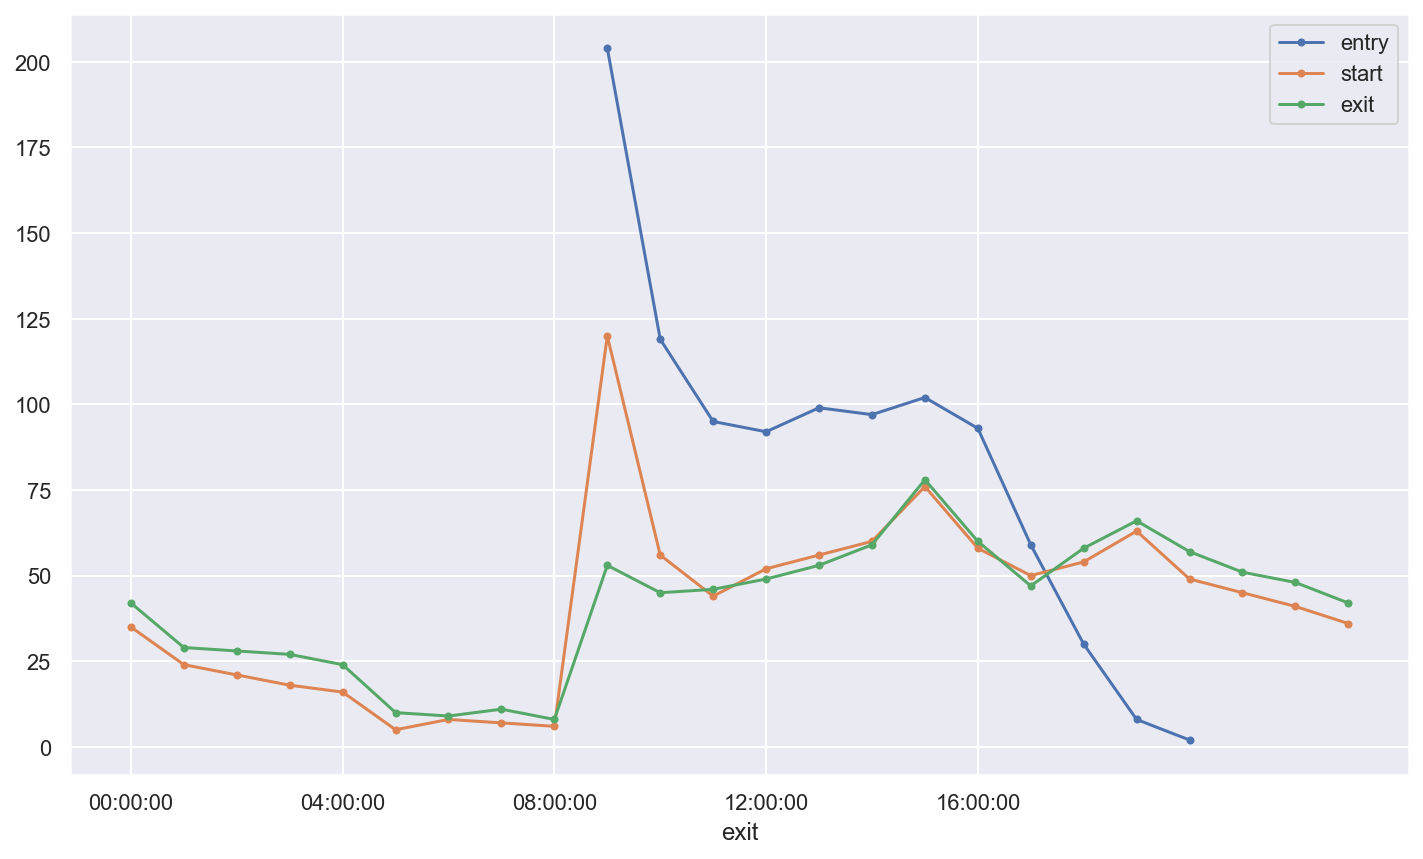

In [110]:
pivots.generic_pivot_time(df.set_index('entry'), time_axes=['hour'], aggfunc='size', reindex_range=(range(24),)).plot(marker='.', label='entry')
pivots.generic_pivot_time(df.set_index('start'), time_axes=['hour'], aggfunc='size', reindex_range=(range(24),)).plot(marker='.', label='start')
pivots.generic_pivot_time(df.set_index('exit'), time_axes=['hour'], aggfunc='size', reindex_range=(range(24),)).plot(marker='.', label='exit')
plt.legend(['entry', 'start', 'exit'])
plt.xticks(**{'ticks': [i * 4 for i in range(5)], 'labels': [datetime.time(hour=i*4) for i in range(5)]})

([<matplotlib.axis.XTick at 0x14d2b265640>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

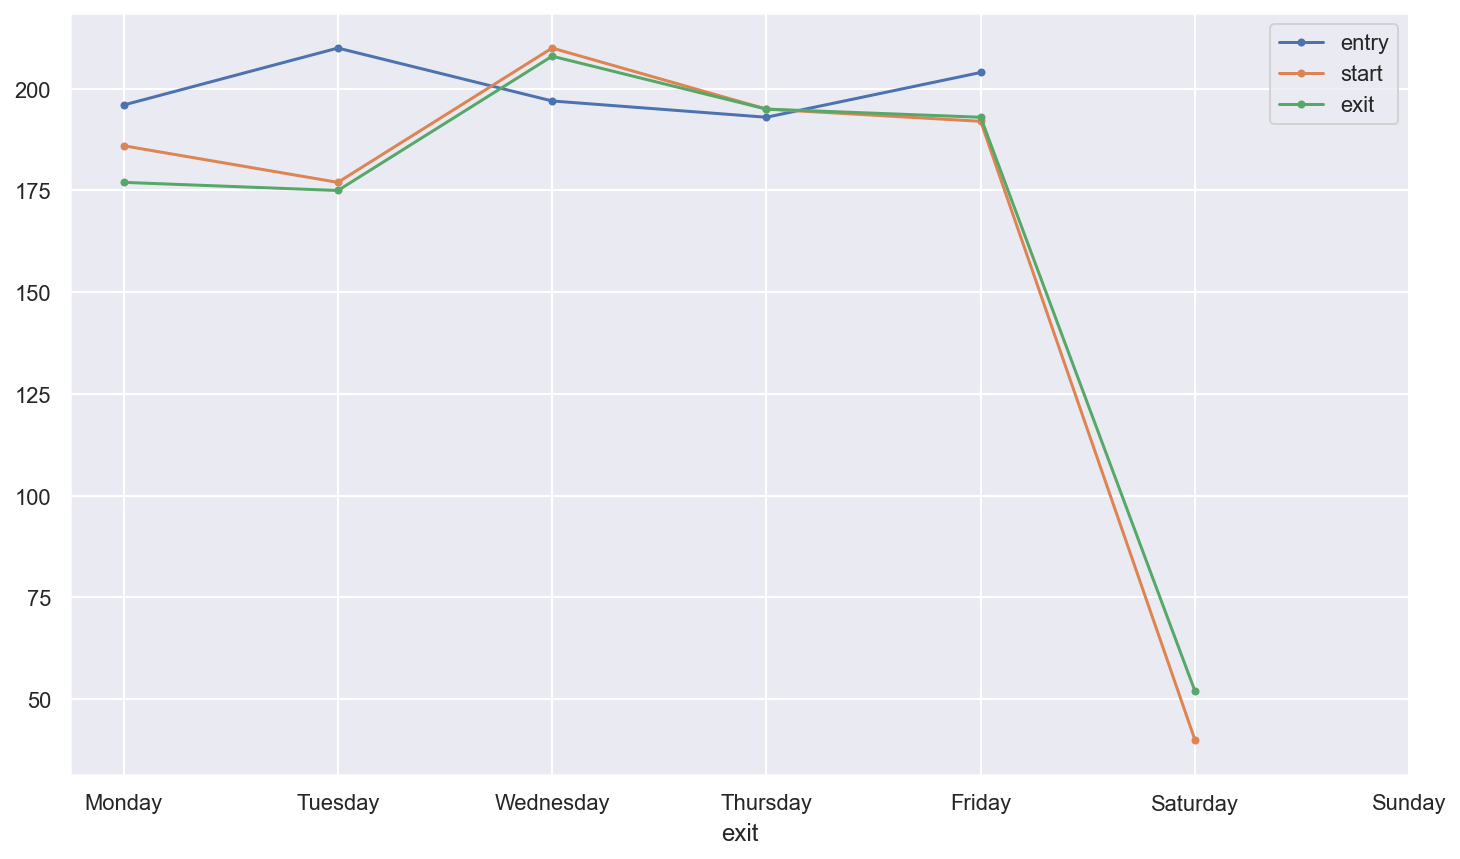

In [111]:
pivots.generic_pivot_time(df.set_index('entry'), time_axes=['dayofweek'], aggfunc='size', reindex_range=(range(7),)).plot(marker='.')
pivots.generic_pivot_time(df.set_index('start'), time_axes=['dayofweek'], aggfunc='size', reindex_range=(range(7),)).plot(marker='.')
pivots.generic_pivot_time(df.set_index('exit'), time_axes=['dayofweek'], aggfunc='size', reindex_range=(range(7),)).plot(marker='.')
plt.legend(['entry', 'start', 'exit'])
plt.xticks(**{'ticks': range(7), 'labels': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

([<matplotlib.axis.XTick at 0x14d2b2d68b0>,
 [Text(1, 0, 'Day 1'),
  Text(4, 0, 'Day 4'),
  Text(7, 0, 'Day 7'),
  Text(10, 0, 'Day 10'),
  Text(13, 0, 'Day 13'),
  Text(16, 0, 'Day 16'),
  Text(19, 0, 'Day 19'),
  Text(22, 0, 'Day 22'),
  Text(25, 0, 'Day 25'),
  Text(28, 0, 'Day 28'),
  Text(31, 0, 'Day 31')])

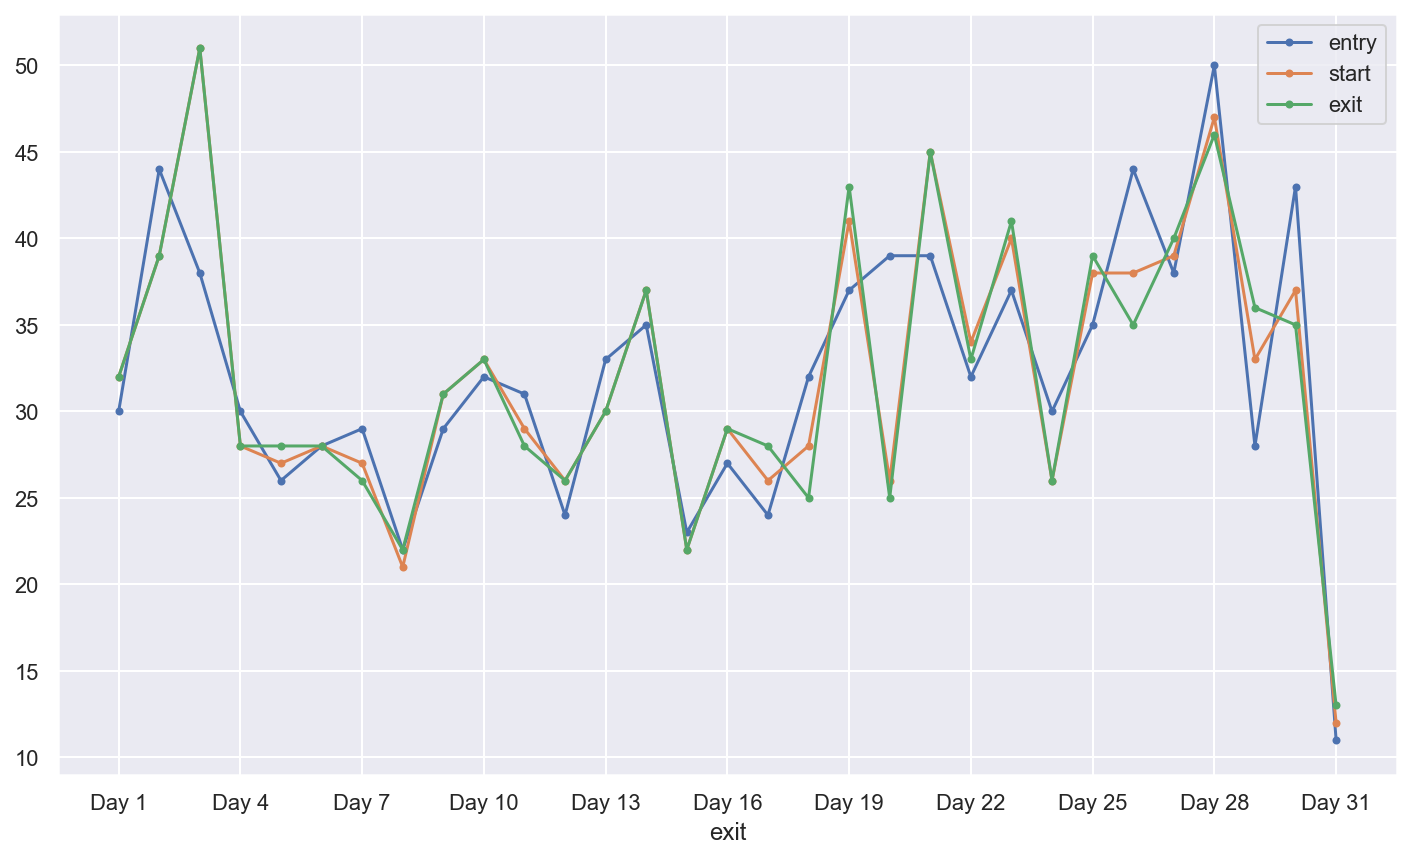

In [112]:
pivots.generic_pivot_time(df.set_index('entry'), time_axes=['day'], aggfunc='size', reindex_range=(range(1,32),)).plot(marker='.')
pivots.generic_pivot_time(df.set_index('start'), time_axes=['day'], aggfunc='size', reindex_range=(range(1,32),)).plot(marker='.')
pivots.generic_pivot_time(df.set_index('exit'), time_axes=['day'], aggfunc='size', reindex_range=(range(1,32),)).plot(marker='.')
plt.legend(['entry', 'start', 'exit'])
plt.xticks(**{'ticks': [1 + 3 * i for i in range(11)], 'labels': [f'Day {1 + 3 * i}' for i in range(11)]})

In [113]:
mean_proc_per_h = df.groupby([df.start.dt.hour, df.exit_resource])['processing_time'].apply(pd.Series.mean)

TypeError: invalid type promotion

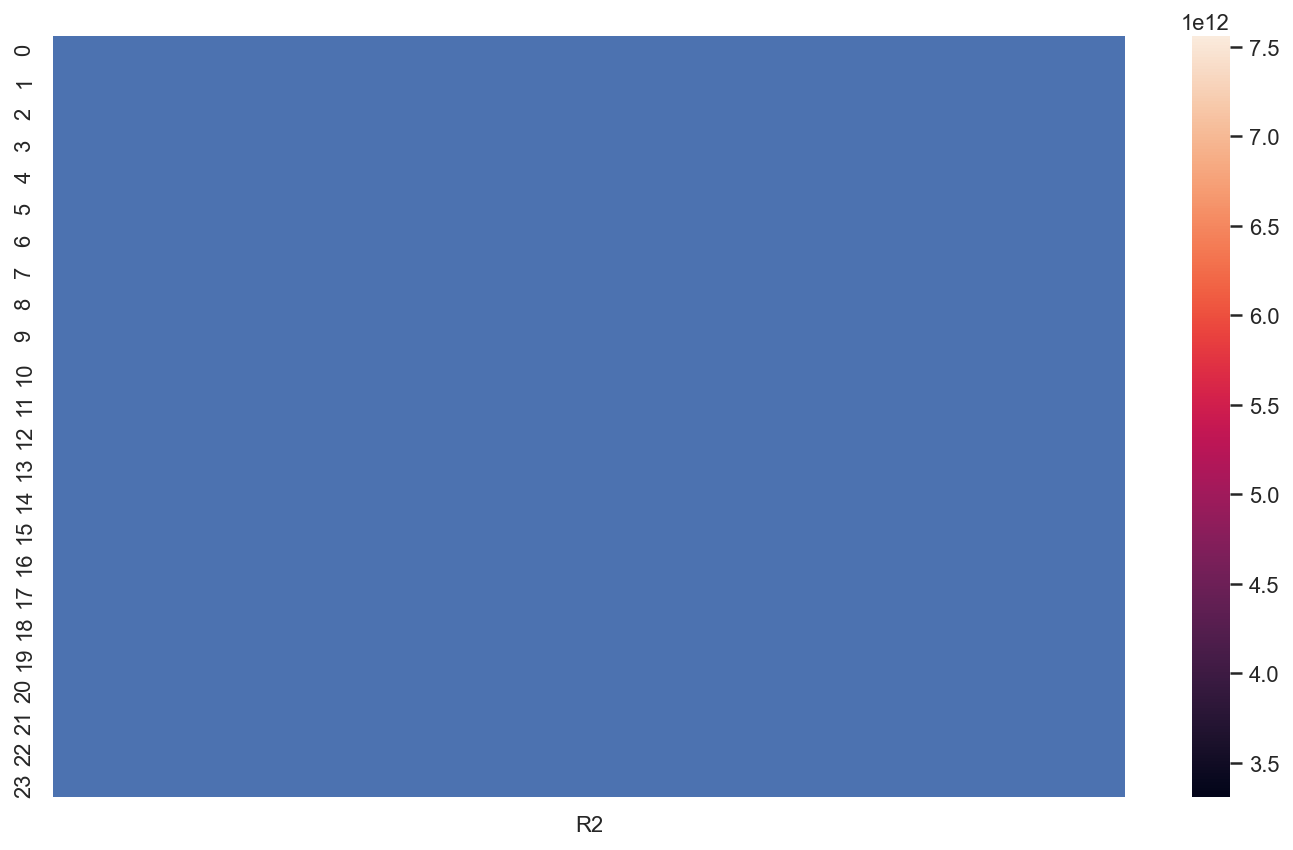

In [114]:
sns.heatmap(mean_proc_per_h.unstack(1).fillna(pd.Timedelta(seconds=0)))

In [ ]:
mean_proc_per_h.unstack(1).fillna(pd.Timedelta(seconds=0))